# Facial recognition via deep learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is a branch of machine learning that relies on [neural networks](https://en.wikipedia.org/wiki/Neural_network) to perform predictive analytics. Neural networks are built with libraries such as [TensorFlow](https://www.tensorflow.org/) and [Keras](https://keras.io/). The latter is an open-source Python library that dramatically simplifies the building of neural networks. Under the hood, it uses TensorFlow and other frameworks to do the heavy lifting. With Keras, you can build sophisticated neural networks with just a few lines of code and train them to classify images, analyze text for sentiment, do natural-language processing, and perform other tasks at which deep learning excels.

In this exercise, you will use Keras to build a series of neural networks that recognize faces. You will train them with images from the famous [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset. Along the way, you will learn the basics of building, training, and evaluating neural networks.

![](Images/lfw.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In total, 1,140 facial images were loaded. Each image measures 62 x 47 pixels for a total of 2,914 pixels per image. That basically means we're working with a model with 2,914 feature columns. Use the following code to show the first 24 images in the dataset and the people to whom the faces belong.

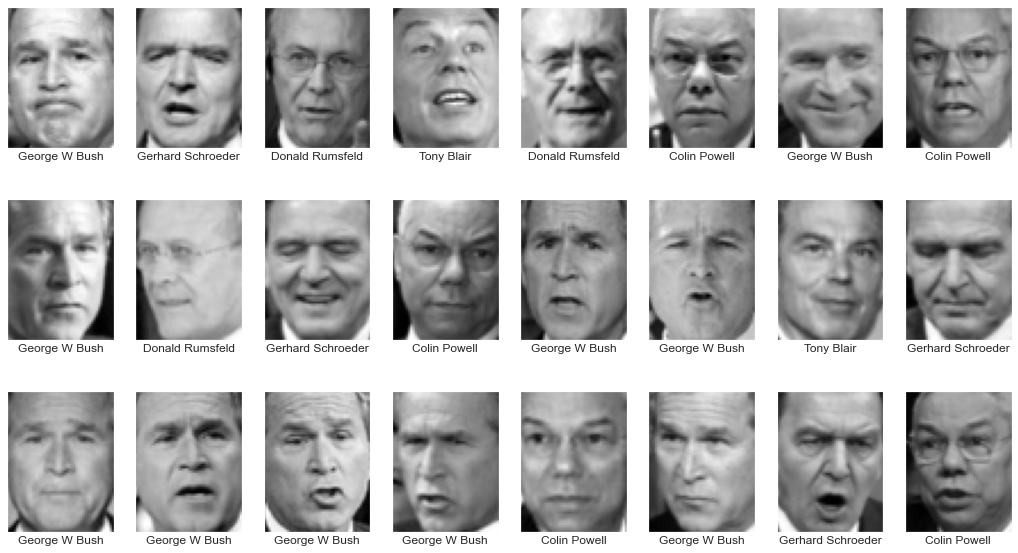

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each person.

<AxesSubplot:>

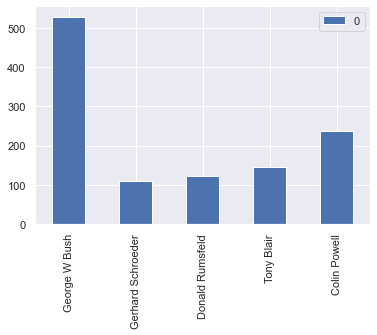

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

The dataset is not very well balanced, and that's a concern because classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

The next step is to normalize pixel values by dividing them by 255, and to convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. After that, we'll split the data for training and testing. Rather than allow Keras to do the splitting, we'll use Scikit-learn's `train_test_split` function because it gives us more control over how the split is performed. And it will allow us to consistently test the network with data it hasn't seen before.

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces / 255
face_labels = to_categorical(y_faces)
                             
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

## Build and train a neural network

We'll start by using Keras to build and train a neural network containing one working layer with 128 neurons. We'll use `categorical_crossentropy` as the loss function and a `softmax` output layer, both of which are appropriate for muticlass classification problems. We will also use `adam` as the optimization algorithm. Rather than use a fixed learning rate, `adam` varies the learning rate as training proceeds so the network learns faster in the early stages of training and (hopefully) converges more accurately toward a solution in later stages.

In [6]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               373120    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 373,765
Trainable params: 373,765
Non-trainable params: 0
_________________________________________________________________


Now let's train the neural network. We'll let it run for 100 epochs and then check the result to see if it required more (or less) training.

In [7]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Epoch 1/100
16/16 [==============================] - 7s 25ms/step - loss: 2.2576 - accuracy: 0.2071 - val_loss: 1.8268 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 1.7118 - accuracy: 0.1921 - val_loss: 1.6770 - val_accuracy: 0.2400
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1.6251 - accuracy: 0.2713 - val_loss: 1.4161 - val_accuracy: 0.6000
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3916 - accuracy: 0.4468 - val_loss: 1.4032 - val_accuracy: 0.4900
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3604 - accuracy: 0.4943 - val_loss: 1.3574 - val_accuracy: 0.4800
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 1.2560 - accuracy: 0.5512 - val_loss: 1.3469 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 1.2476 - accuracy: 0.6164 - val_loss: 1.3545 - val_accuracy: 0.4500
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2192 - accuracy: 0.9428 - val_loss: 0.6844 - val_accuracy: 0.7800
Epoch 60/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9738 - val_loss: 0.6883 - val_accuracy: 0.7800
Epoch 61/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9618 - val_loss: 0.6642 - val_accuracy: 0.8000
Epoch 62/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1839 - accuracy: 0.9778 - val_loss: 0.7482 - val_accuracy: 0.7000
Epoch 63/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2654 - accuracy: 0.9129 - val_loss: 0.7383 - val_accuracy: 0.7800
Epoch 64/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1724 - accuracy: 0.9587 - val_loss: 0.9472 - val_accuracy: 0.6300
Epoch 65/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 0.8820 - val_loss: 0.8174 - val_accuracy: 0.7700
Epoch 

Keras's `fit` function returns a `history` object containing information about the training and validation accuracies measured following each epoch of the training. Let's use that information to plot the training and validation accuracy over time.

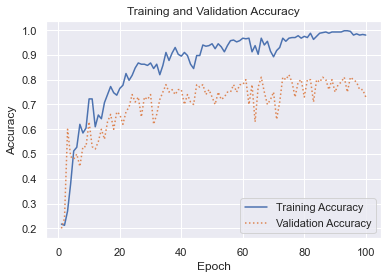

In [8]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

In all likelihood, the training accuracy approached 100% (1.0) in later epochs, while the validation accuracy peaked out between 80% and 90%. Let's try widening the working layer to 512 neurons and comparing the results.

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 4.3971 - accuracy: 0.1629 - val_loss: 1.9945 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 1.8905 - accuracy: 0.2501 - val_loss: 1.5436 - val_accuracy: 0.3300
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 1.5081 - accuracy: 0.3730 - val_loss: 1.4828 - val_accuracy: 0.3200
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 1.4286 - accuracy: 0.3907 - val_loss: 1.4347 - val_accuracy: 0.3700
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2962 - accuracy: 0.5290 - val_loss: 1.4742 - val_accuracy: 0.3200
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 1.4006 - accuracy: 0.3888 - val_loss: 1.5570 - val_accuracy: 0.3700
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 1.4032 - accuracy: 0.4925 - val_loss: 1.3709 - val_accuracy: 0.3700
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1935 - accuracy: 0.9390 - val_loss: 0.8424 - val_accuracy: 0.7200
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2410 - accuracy: 0.9249 - val_loss: 1.0248 - val_accuracy: 0.6800
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9309 - val_loss: 1.1021 - val_accuracy: 0.6900
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2400 - accuracy: 0.9078 - val_loss: 0.6445 - val_accuracy: 0.7900
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1515 - accuracy: 0.9703 - val_loss: 0.6989 - val_accuracy: 0.8300
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9742 - val_loss: 0.8601 - val_accuracy: 0.7600
Epoch 65/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1444 - accuracy: 0.9700 - val_loss: 0.8185 - val_accuracy: 0.7700
Epoch 

Once more, we will plot the accuracy over time to assess how well the network learned from the training data.

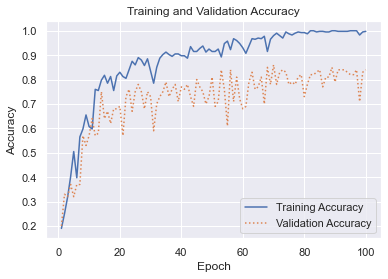

In [10]:
show_history(hist)

Were the results significantly different than before? Probably not. But now let's modify the network so that it contains four hidden layers of 128 neurons each. It's the same number of neurons as the previous model, but the network itself is narrower and deeper. You should find that this model trains somewhat faster.

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 1.6745 - accuracy: 0.2259 - val_loss: 1.6456 - val_accuracy: 0.2100
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 1.6498 - accuracy: 0.2028 - val_loss: 1.5901 - val_accuracy: 0.3300
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1.5961 - accuracy: 0.2667 - val_loss: 1.5817 - val_accuracy: 0.2100
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 1.5434 - accuracy: 0.2536 - val_loss: 1.5030 - val_accuracy: 0.3200
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 1.4948 - accuracy: 0.3106 - val_loss: 1.5272 - val_accuracy: 0.2900
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 1.4285 - accuracy: 0.3196 - val_loss: 1.4145 - val_accuracy: 0.4100
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 1.2851 - accuracy: 0.4234 - val_loss: 1.3683 - val_accuracy: 0.3600
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2370 - accuracy: 0.9270 - val_loss: 1.5280 - val_accuracy: 0.6700
Epoch 60/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7621 - accuracy: 0.7710 - val_loss: 1.0508 - val_accuracy: 0.6300
Epoch 61/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8766 - val_loss: 0.6646 - val_accuracy: 0.8200
Epoch 62/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1307 - accuracy: 0.9547 - val_loss: 0.7014 - val_accuracy: 0.7800
Epoch 63/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.9603 - val_loss: 0.8949 - val_accuracy: 0.7500
Epoch 64/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9445 - val_loss: 1.2882 - val_accuracy: 0.6700
Epoch 65/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2667 - accuracy: 0.9039 - val_loss: 0.7524 - val_accuracy: 0.7600
Epoch 

Now let's see what happened during training.

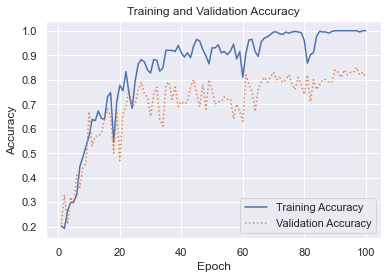

In [12]:
show_history(hist)

Expanding to four hidden layers doesn't seem to help much in terms of accuracy, so let's back off again to one layer. You never want more layers (or more neurons) than necessary, and too many can prevent the model from generalizing well.

In [13]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Epoch 1/100
16/16 [==============================] - 1s 12ms/step - loss: 2.8728 - accuracy: 0.2368 - val_loss: 1.6755 - val_accuracy: 0.3300
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 1.6946 - accuracy: 0.2653 - val_loss: 1.5264 - val_accuracy: 0.3300
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1.5673 - accuracy: 0.3851 - val_loss: 1.5009 - val_accuracy: 0.4700
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3998 - accuracy: 0.4363 - val_loss: 1.4061 - val_accuracy: 0.3800
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3484 - accuracy: 0.4655 - val_loss: 1.3945 - val_accuracy: 0.4700
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3419 - accuracy: 0.4874 - val_loss: 1.3579 - val_accuracy: 0.3600
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 1.2021 - accuracy: 0.4939 - val_loss: 1.2541 - val_accuracy: 0.5800
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9573 - val_loss: 0.7750 - val_accuracy: 0.7100
Epoch 60/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2936 - accuracy: 0.9154 - val_loss: 0.7852 - val_accuracy: 0.7700
Epoch 61/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2236 - accuracy: 0.9477 - val_loss: 0.6369 - val_accuracy: 0.8500
Epoch 62/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9619 - val_loss: 0.6338 - val_accuracy: 0.8200
Epoch 63/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9665 - val_loss: 0.6443 - val_accuracy: 0.8200
Epoch 64/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9563 - val_loss: 0.6990 - val_accuracy: 0.8000
Epoch 65/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9494 - val_loss: 0.7615 - val_accuracy: 0.8100
Epoch 

Time to check the results.

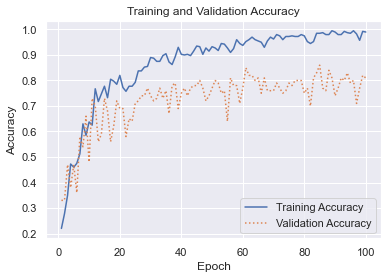

In [14]:
show_history(hist)

Did you notice that the chart above isn't a perfect match for the one you generated for the same network earlier? Keras and TensorFlow use random numbers to initialize neural networks, to shuffle training data between training epochs, to help optimization algorithms converge on the best solution as training takes place, and more. This means that you can train the same model 10 times using the same data and get 10 different results. This is a feature, not a bug. Once they arrive at the right network architecture, data scientists will often train a neural network 20 or more times and average the results to get the best measure of the network's accuracy.

At this point, it might be helpful to run some test data through the network and generate a confusion matrix showing how it performed. We can use Scikit-learn's `confusion_matrix` function to generate the confusion matrix and seaborn to plot it.

Text(89.18, 0.5, 'Actual label')

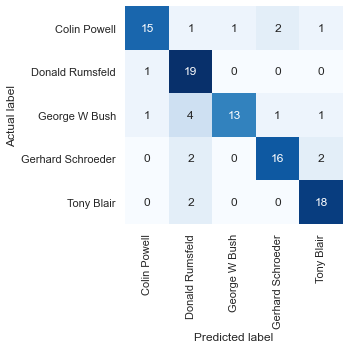

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the model correctly identify George W. Bush? How many times did it identify him as someone else?

## Use dropout to increase generalization

The fact that training accuracy approaches 100% (1.0) tells us that the network is deep enough and wide enough to learn from the facial data we train it with. But the validation accuracy peaks out much lower. This means that the model isn't *generalizing* well — that is, it isn't responding as well as we would like to facial images it hasn't seen. One way to mitigate that is to introduce *dropout* during training.

Dropout is a commonly used technique to help neural networks generalize better. In Keras, you can introduce dropout by following a `Dense` layer with a `Dropout` layer, specifying the fraction of connections that should be randomly dropped between layers in each training epoch. Let's introduce dropout to the network and see if it has an effect on the network's validation accuracy. Because dropout causes the model to train more slowly, we'll increase the number of epochs to 200.

In [16]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=25)

Epoch 1/200
16/16 [==============================] - 1s 13ms/step - loss: 2.4571 - accuracy: 0.1804 - val_loss: 1.6387 - val_accuracy: 0.2000
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 1.6760 - accuracy: 0.2137 - val_loss: 1.5963 - val_accuracy: 0.2100
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 1.5691 - accuracy: 0.2732 - val_loss: 1.5591 - val_accuracy: 0.3400
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 1.5690 - accuracy: 0.2515 - val_loss: 1.5455 - val_accuracy: 0.3300
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 1.4928 - accuracy: 0.3464 - val_loss: 1.5021 - val_accuracy: 0.4100
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 1.4939 - accuracy: 0.3428 - val_loss: 1.5083 - val_accuracy: 0.4200
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 1.4787 - accuracy: 0.3685 - val_loss: 1.5344 - val_accuracy: 0.2400
Epoch 8/200


Epoch 59/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7447 - accuracy: 0.7072 - val_loss: 0.8321 - val_accuracy: 0.7700
Epoch 60/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7121 - accuracy: 0.7310 - val_loss: 0.8164 - val_accuracy: 0.7600
Epoch 61/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7385 - accuracy: 0.7246 - val_loss: 0.8195 - val_accuracy: 0.7800
Epoch 62/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7270 - accuracy: 0.7384 - val_loss: 0.8484 - val_accuracy: 0.7700
Epoch 63/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7194 - accuracy: 0.6921 - val_loss: 0.9508 - val_accuracy: 0.6400
Epoch 64/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7887 - accuracy: 0.6601 - val_loss: 0.8022 - val_accuracy: 0.8000
Epoch 65/200
16/16 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.7163 - val_loss: 0.8060 - val_accuracy: 0.7700
Epoch 

16/16 [==============================] - 0s 2ms/step - loss: 0.4927 - accuracy: 0.8015 - val_loss: 0.6491 - val_accuracy: 0.8400
Epoch 117/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4462 - accuracy: 0.8175 - val_loss: 0.6789 - val_accuracy: 0.8100
Epoch 118/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.7937 - val_loss: 0.7147 - val_accuracy: 0.8100
Epoch 119/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.8165 - val_loss: 0.6421 - val_accuracy: 0.8400
Epoch 120/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.8141 - val_loss: 0.6349 - val_accuracy: 0.8400
Epoch 121/200
16/16 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7850 - val_loss: 0.6759 - val_accuracy: 0.8400
Epoch 122/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.8074 - val_loss: 0.6620 - val_accuracy: 0.8400
Epoch 123/200

16/16 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.8374 - val_loss: 0.6795 - val_accuracy: 0.8300
Epoch 174/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3969 - accuracy: 0.8303 - val_loss: 0.6193 - val_accuracy: 0.8500
Epoch 175/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.8140 - val_loss: 0.6706 - val_accuracy: 0.7900
Epoch 176/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.9051 - val_loss: 0.7969 - val_accuracy: 0.7300
Epoch 177/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3244 - accuracy: 0.8842 - val_loss: 0.6770 - val_accuracy: 0.8300
Epoch 178/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3470 - accuracy: 0.8691 - val_loss: 0.6360 - val_accuracy: 0.8500
Epoch 179/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3781 - accuracy: 0.8282 - val_loss: 0.5936 - val_accuracy: 0.8400
Epoch 180/200

Now let's plot the training history. Does the model seem to generalize better?

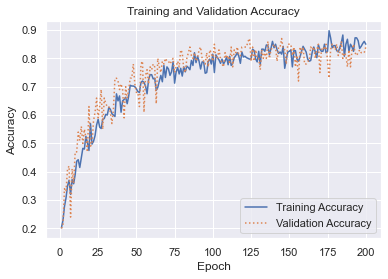

In [17]:
show_history(hist)

While the gap between training accuracy and validation accuracy probably narrowed, validation accuracy probably didn't improve much. That might be an indication that more training data is needed to make the network "smarter." Generally speaking, image classifiers do better when they have more data to learn from.